In [1]:
import pandas as pd

In [2]:
from helpers.plotting import plot_rolling

In [28]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [4]:
df = pd.read_json('../data/A2ZINFRA.json')

In [12]:
df_train = df['c'].iloc[:int(0.8*len(df['c']))]

In [13]:
df_train

0       328.55
1       332.10
2       325.45
3       317.65
4       317.00
         ...  
2505      4.65
2506      4.60
2507      4.55
2508      4.60
2509      4.45
Name: c, Length: 2510, dtype: float64

<Figure size 432x288 with 0 Axes>

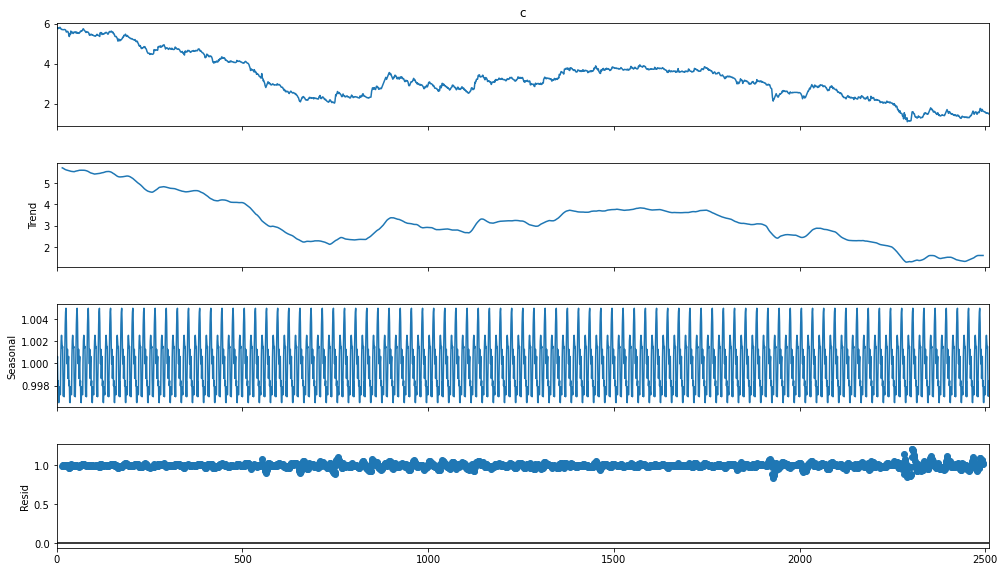

In [21]:
result = seasonal_decompose(np.log(df_train), model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

In [22]:
df_log = np.log(df['c'])

In [23]:
train_data, test_data = df_log[3:int(len(df_log)*0.8)], df_log[int(len(df_log)*0.8):]

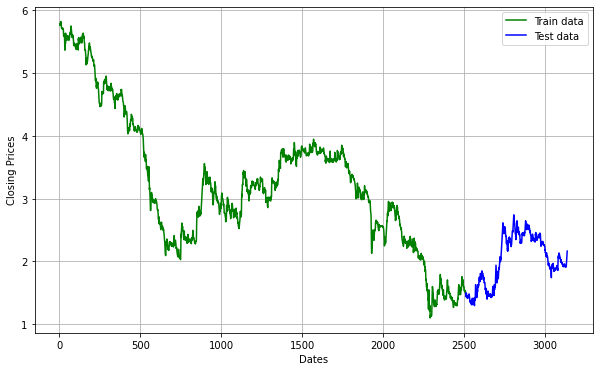

In [24]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9166.123, Time=0.41 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9199.130, Time=0.41 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9196.581, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-9163.306, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-9200.552, Time=0.31 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-9201.324, Time=0.25 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-9199.533, Time=0.36 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-9190.429, Time=1.38 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-9200.029, Time=0.32 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0] intercept
Total fit time: 3.987 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2507
Model:               SARIMAX(3, 1, 0)   Log Likelihood                4605.662
Date:                Wed, 23 Aug 2023   

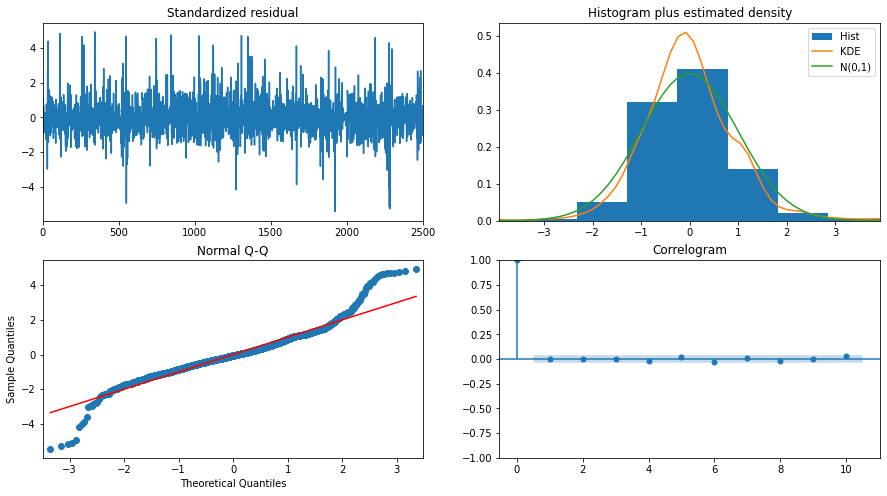

In [26]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [30]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(3,1,0))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                      c   No. Observations:                 2507
Model:                 ARIMA(3, 1, 0)   Log Likelihood                4604.014
Date:                Wed, 23 Aug 2023   AIC                          -9200.029
Time:                        18:07:07   BIC                          -9176.723
Sample:                             0   HQIC                         -9191.568
                               - 2507                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1138      0.013      9.048      0.000       0.089       0.139
ar.L2          0.0344      0.017      2.058      0.040       0.002       0.067
ar.L3          0.0346      0.016      2.159      0.0

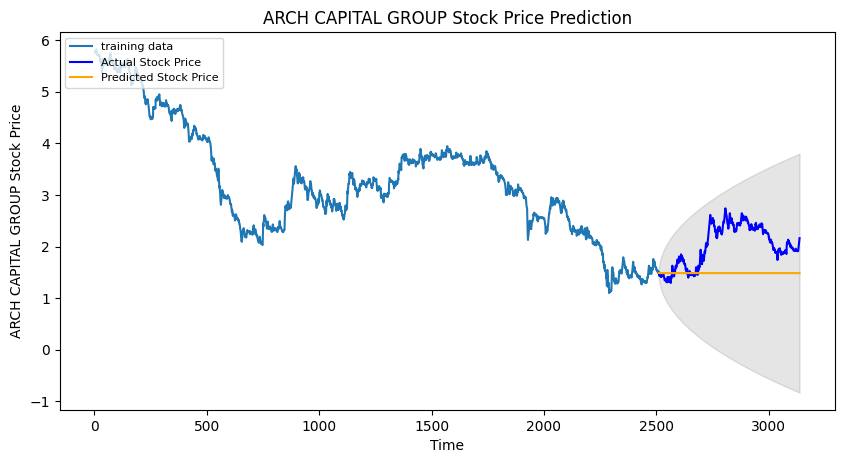

In [46]:
# Forecast
fe = fitted.get_forecast(len(test_data), alpha=0.05).summary_frame()  # 95% conf
fc_series = fe['mean']
conf_l = fe['mean_ci_lower']
conf_u = fe['mean_ci_upper']

# Make as pandas series
fc_series = pd.Series(fc_series, index=test_data.index)
lower_series = pd.Series(conf_l, index=test_data.index)
upper_series = pd.Series(conf_u, index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()